In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence
from utils import FKL, plot_distribs
from utils import GaussianParticle, GaussianMixture

## 1. Fitting simple Gaussians

### 1.1 RKL

We use PyTorch's kl_divergence method.

In [2]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    requires_grad=True
)

# Non trainable Gaussian particle, target of the model.
target = GaussianParticle(
    loc=torch.tensor([3,3], dtype=torch.float),
    scale_tril=0.3*torch.eye(2),
    requires_grad=False
)

Visualizing the distributions at initialization:

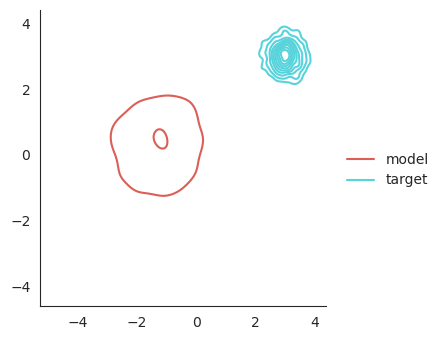

In [3]:
plot_distribs({'model':model, 'target':target})

In [4]:
# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.01)

losses = []
for step in range(2000):
    loss = kl_divergence(p=target.mvn, q=model.mvn)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    losses.append(loss.detach().numpy())
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

step:0, loss:13.949718475341797
step:200, loss:3.2768874168395996
step:400, loss:2.032214641571045
step:600, loss:1.6895973682403564
step:800, loss:1.3603591918945312
step:1000, loss:0.7731879353523254
step:1200, loss:8.344650268554688e-07
step:1400, loss:-1.1920928955078125e-07
step:1600, loss:-1.1920928955078125e-07
step:1800, loss:-1.1920928955078125e-07


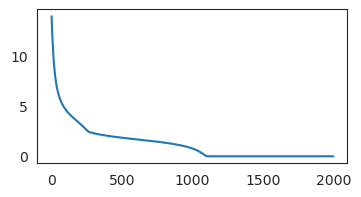

In [7]:
plt.figure(figsize=(4,2))
plt.plot(losses)
plt.show()

Visualizing the distributions after optimization:

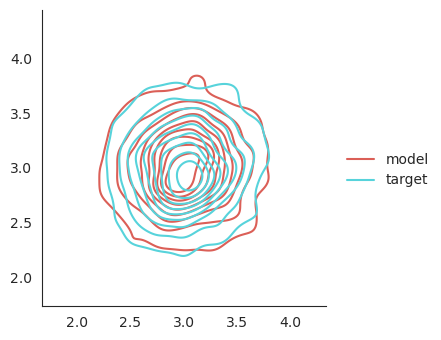

In [8]:
plot_distribs({'model':model, 'target':target})

### 1.2 FKL

The main difference is that we need to initialize our model, we choose a centered and diffuse Gaussian distribution.

In [12]:
# Non trainable Gaussian particle, target of the model.
target = GaussianParticle(
    loc=torch.tensor([2,2], dtype=torch.float),
    scale_tril=0.3*torch.eye(2),
    requires_grad=False
)

# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    requires_grad=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    requires_grad=True
)

In [13]:
# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.01)

losses = []
for step in range(2000):
    loss = FKL(
        f=particle,
        q=model,
        p=target
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    losses.append(loss.detach().numpy())
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

step:0, loss:4.1209259033203125
step:200, loss:0.16303272545337677
step:400, loss:0.0706598088145256
step:600, loss:0.02838561311364174
step:800, loss:0.02117357775568962
step:1000, loss:0.011165470816195011
step:1200, loss:0.018880685791373253
step:1400, loss:-0.046916671097278595
step:1600, loss:0.025204043835401535
step:1800, loss:0.04733375832438469


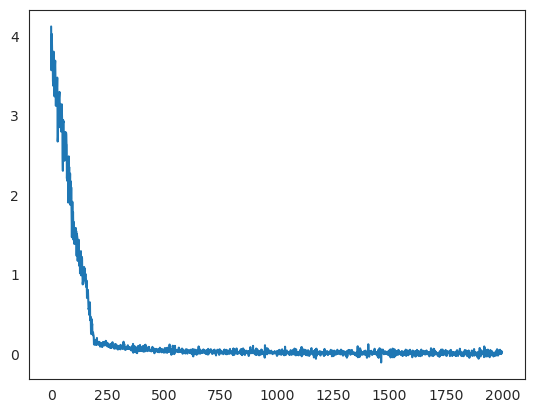

In [14]:
plt.plot(losses)
plt.show()

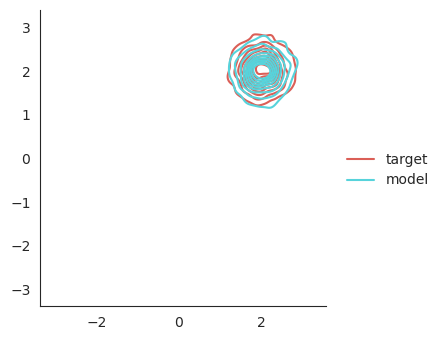

In [15]:
plot_distribs({'target':target, 'model':model})

## 2. Fitting a multimodal target

Defining the target:

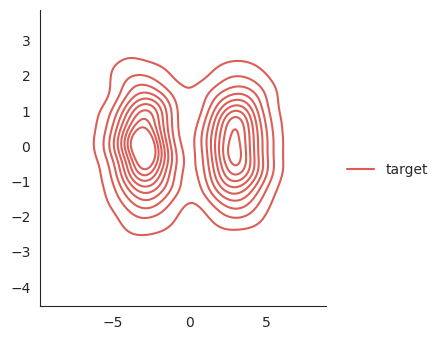

In [18]:
# Non trainable gaussian mixture:
particle1 = GaussianParticle(
    loc=torch.tensor([3,0], dtype=torch.float),
    scale_tril=torch.eye(2),
    requires_grad=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-3,0], dtype=torch.float),
    scale_tril=torch.eye(2),
    requires_grad=False
)
target = GaussianMixture(particle1)
target.add_particle(particle2)

plot_distribs({'target':target}, nsamples=2000)

### 2.1 RKL

### 2.2 FKL

We initialize a model with a centered diffuse gaussian:

In [62]:
init = GaussianParticle(
    loc=torch.tensor([0,0], dtype=torch.float),
    covariance_matrix=2*torch.eye(2),
    requires_grad=False
)
gm_model = GaussianMixture(init)

In [63]:
### LET US NOW TRY TO FIT A GM ON THE TARGET ###
K = 2

for i in range(K):
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        covariance_matrix=torch.eye(2),
        requires_grad=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=0.001)

    losses = []
    for step in range(5000):
        loss = FKLLoss(
            f=new_particle,
            q=gm_model,
            p=gm_target,
            nsamples=2000
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        losses.append(loss.detach().numpy())
        if step%300==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    gm_model.add_particle(new_particle)

step:0, loss:0.44570279121398926
step:300, loss:0.38854506611824036
step:600, loss:0.4054751992225647
step:900, loss:0.3869050145149231
step:1200, loss:0.39865875244140625
step:1500, loss:0.34448710083961487
step:1800, loss:0.3607977032661438
step:2100, loss:0.39003801345825195
step:2400, loss:0.3763396739959717
step:2700, loss:0.37425392866134644
step:3000, loss:0.36620041728019714
step:3300, loss:0.33659201860427856
step:3600, loss:0.3627997636795044
step:3900, loss:0.3642769753932953
step:4200, loss:0.34900787472724915
step:4500, loss:0.33994972705841064
step:4800, loss:0.34943509101867676
step:0, loss:0.6833874583244324
step:300, loss:0.4062383770942688
step:600, loss:0.3294217586517334
step:900, loss:0.25573045015335083
step:1200, loss:0.2235669195652008
step:1500, loss:0.1693698912858963
step:1800, loss:0.17253035306930542
step:2100, loss:0.14379137754440308
step:2400, loss:0.1293383687734604
step:2700, loss:0.13250237703323364
step:3000, loss:0.14102375507354736
step:3300, loss:

In [64]:
gm_model.weights

tensor([0.5037, 0.1753, 0.3210])

In [67]:
gm_model.particles[1].loc

Parameter containing:
tensor([-2.2649, -0.0095])

In [68]:
gm_model.particles[2].loc

Parameter containing:
tensor([2.1940, 0.0054])

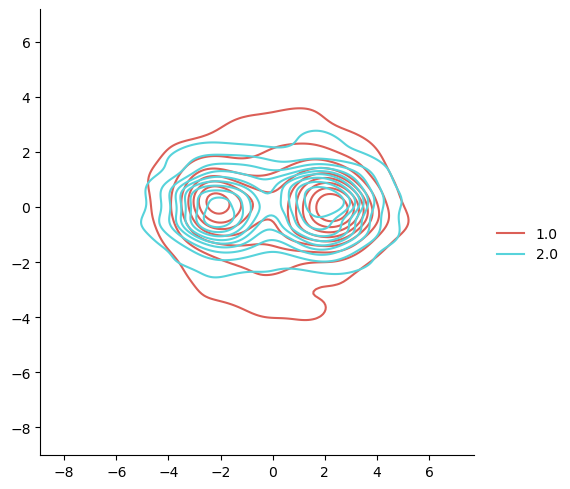

In [65]:
plot_distribs([gm_model, gm_target])

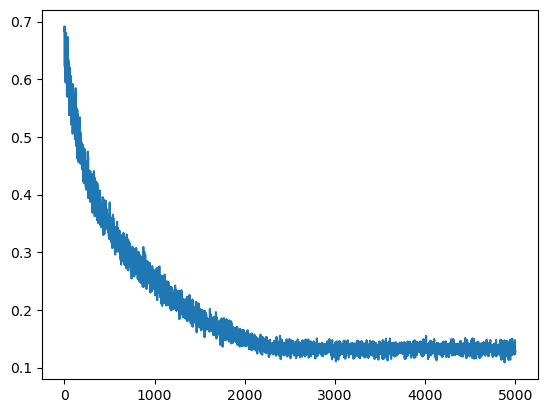

In [66]:
plt.plot(losses)
plt.show()